# __Analysis of data scraped from Kayak__
## Overview

This analysis is __an attempt to find relevant insights__ to determinate if there is __potential improvements in the client's experience offered by Kayak__ based on the data displayed on their platform. __The client__ in this case would be a travel agency or particular that might be __interested in offering new tours/experiences__ in the city of Porto or another location that the tourism is __an essential part of the local economy.__ 

There are some variables which can be used to conduct some exploration that might result in interesting findings for this study.

The data is contained in __2 dataframes__, the first one contains the __general information per attraction__ and includes __270 observations with 15 variables__ and the second one contains the __reviews from the attractions__ and includes __423 observations with 4 variables__. 

The data is a __result of a scraper model created for this study__ (code below) where the aim in this case was the extraction of the __information in the section 'Thing to do' for the city of Porto__, focused specifically on the __category of Food & drinks__ and not all of the categories as it is a __first approach to determinate if it is relevant to expand the exploration to more cities and regions due to the time that the scraper require to retrieve the data to be analyzed.__ 

In a next stage __the idea is to expand the scope of the analysis__ to be able to have a broader view of how to improve the client experience offered to the client.

__Following variables are available in the Main dataframe:__

Title, Location, Link, Score, Number of ratings, Price,Currency, Unit, Description, Ticket options, Free cancellation, Languages, Duration, Disability & Food and drink    

__Following variables are available in the Reviews dataframe:__

Thing to do, Reviewer, Rating, Review

# Kayak scraper

As the intention of the study was to conduct an analysis of the information of Kayak about the city of Porto, __I did not found any Dataframe available that could be useful__ for me, for this reason, i decided to __model my own version of a Kayak scraper__ using Selenium and BeautifulSoup to get the relevant information that i would need.

_*The code below was ran in a different notebook that can be seen in the same folder as this notebook._

___Disclaimer: this model was created with the sole purpose of personal, non-commercial use to apply for a job in Kayak and  give a glimpse of what I can do working at the company as a Data Scientist. All the text is from their own property as they explain in https://www.kayak.co.id/terms-of-use.___

In [ ]:
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import os
import io
import sys
import bs4
from bs4 import BeautifulSoup
import time
import codecs
import requests
import urllib.request
import urllib.parse
import pandas as pd
from datetime import date, timedelta
import datetime
import numpy as np
import random

In [ ]:
def get_df():
    df =pd.DataFrame(columns = ['Title', 'Location', 'Link', 'Score', 'Number of ratings', 'Price','Currency', 'Unit', 'Description', 'Ticket options'
                                      , 'Free cancellation', 'Languages', 'Duration', 'Disability', 'Food and drink'])
    df = df[df.columns[0:]]
    return df

def get_reviews_df():
    df =pd.DataFrame(columns = ['Thing to do', 'Reviewer', 'Rating', 'Review'])
    df = df[df.columns[0:]]
    return df

def get_dic(df):
    return {c: None for c in df.columns}

def trans_df(dict_a):
    return pd.DataFrame(data = [[dict_a[x] for x in dict_a.keys()]], columns=list(dict_a.keys()))

def about_check(x):
    ticket_check = 'Ticket options'
    cancellation_check = 'Free cancellation'
    language_check = 'Languages'
    duration_check = 'Duration'
    disability_check = 'Disability'
    food_check = 'Food and drink'
    if ticket_check in x:
        main_dict['Ticket options'] = x.replace(ticket_check, '')
    elif cancellation_check in x:
        main_dict['Free cancellation'] = x.replace(cancellation_check, '')
    elif language_check in x:
        main_dict['Languages']  = x.replace(language_check, '')
    elif duration_check in x:
        main_dict['Duration']  = x.replace(duration_check, '')
    elif disability_check in x:
        main_dict['Disability']  = x.replace(disability_check, '')
    elif food_check in x:
        main_dict['Food and drink']  = x.replace(food_check, '') 
    else:
        main_dict['Food and drink'] = None
        main_dict['Disability'] = None
        main_dict['Duration'] = None
        main_dict['Languages'] = None
        main_dict['Free cancellation'] = None
        main_dict['Ticket options'] = None
    return x

def click_read_more(browser):
    try:
        read_more_bt = browser.find_element_by_xpath('//*[@id="root"]/div/div[2]/div/div[2]/section[3]/div/div/ol/li/div/div/span/button')
        #read_more_bt = read_more_bt.find_element_by_link_text('Read more')
        read_more_bt.click()
    except Exception as e:
        print (e)
        
def click_next_button(browser):
    try:
        next_bt = WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'xITt-next-page')))
        next_bt.click()
    except Exception as e:
        print (e)


## Get links to scrape

In [ ]:
brow = webdriver.Chrome('./chromedriver')
brow.get("https://www.kayak.co.uk/things-to-do/Porto,Portugal-c15957?sort=userRating_b&fs=topCategories=9")
for x in range(150):
    rand = random.randint(0,3)
    rand_scroll = random.randint(350,912)
    brow.execute_script('window.scrollBy(0, '+str(rand_scroll)+')')
    time.sleep(rand)
    time.sleep(0.25)
    time.sleep(0.25)
web = BeautifulSoup(brow.page_source)
link_list = []
link = web.find_all('a',{'class':'c4Hod-cta-link'})
for x in link:
    lk = x.attrs['href']
    lk = 'https://www.kayak.co.uk' + str(lk)
    link_list.append(lk)
    print(lk)
file = open('link_list.txt', 'w')
for x in link_list:
    file.write(x + ',')
file.close()
########## Loading file ###########
#file = open('link_list.txt', 'r')
#link_list = file.read().split(',')
#link_list

## Things to do Scraper

In [ ]:
main_df = get_df()
main_dict = get_dic(main_df)
reviews_df = get_reviews_df()
dict_reviews = get_dic(reviews_df)

In [ ]:
for y in link_list:
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--disable-extensions')
    chrome_options.add_argument('--profile-directory=Default')
    chrome_options.add_argument("--incognito")
    chrome_options.add_argument("--disable-plugins-discovery");
    chrome_options.add_argument("--start-maximized")
    brow = webdriver.Chrome('./chromedriver', chrome_options = chrome_options)
    brow.delete_all_cookies()
    brow.set_window_size(800,800)
    brow.set_window_position(0,0)
    brow.get(y)
    body = brow.find_element_by_css_selector('body')
    time.sleep(0.25)
    time.sleep(0.25)
    body.send_keys(Keys.SPACE)
    web = BeautifulSoup(brow.page_source)
    main_dict['Link'] = y
    header = web.find('header',{'class':'c0IRO'})
    header = header.find('div',{'class':'c0IRO-main-header'})
    try:
        main_dict['Title'] = header.find('h1').get_text()
        title = main_dict['Title']
        print(main_dict['Title'])
    except:
        pass
    time.sleep(1)
    time.sleep(0.25)
    try:
        location = header.find('span',{'class':'c0IRO-location c0IRO-pres-with-separator'}).get_text()
        main_dict['Location'] = location
        print(main_dict['Location'])
    except:
        main_dict['Location'] = None
    try:
        price = header.find('span',{'class':'c0IRO-price-share'})
        price = header.find('span',{'class':'c0IRO-price'})
        price = price.find('span',{'class':'c0IRO-amount'}).get_text()
        main_dict['Price']= price.replace('£','')
    except:
        main_dict['Price']= None
    try:
        price_unit = header.find('span',{'class':'c0IRO-info'}).get_text()
        main_dict['Unit'] = price_unit.replace('/','')
        main_dict['Currency'] = 'GBP'
    except:
        main_dict['Unit'] = None
    try:
        content = web.find('p',{'class':'WM8v-content'}).get_text()
        main_dict['Description'] = content
    except:
        main_dict['Description'] = None
    try:
        about = web.find_all('div',{'class':'HhAb-item'})
        reviews_section = web.find('div',{'class':'aIp6'})
        main_dict['Score'] = reviews_section.find('span',{'class':'aIp6-number'}).get_text()
        ratings_number = reviews_section.find('span',{'class':'aIp6-based'}).get_text()
        rt = ratings_number.split(' ')
        time.sleep(1)
        time.sleep(0.25)
        main_dict['Number of ratings'] = rt[2]
        print(main_dict['Number of ratings'])
    except:
        main_dict['Number of ratings'] = None
    ab_lst = []
    try:
        for x in about:
            ab = x.get_text()
            ab_lst.append(ab)
        leng = len(ab_lst)
        time.sleep(1)
        time.sleep(0.25)
    except:
        pass
    try:
        for x in range(leng):
            #this can be a function defined
            about_check(ab_lst[x])
            print(ab_lst[x])
    except:
        pass
    trans = trans_df(main_dict)
    main_df = pd.concat([main_df, trans], ignore_index = True)
    
    brow.close()

In [ ]:
main_df.to_excel("porto_things2.xlsx")

In [ ]:
reviews_df.to_excel('reviews_porto_things.xlsx')

# Reviews analysis

After getting the results from the scraper, the __first dataframe that I wanted to analyze was the Reviews dataframe__ as it has less Variables, therefore the analysis might be more simple to start having an idea of potential insights about what are the users of the platform saying about the things to do in Porto.

for this analysis first __the data was cleaned, handled the missing values, removed stopwords, lower the text and split the reviews per words.__

This analysis includes __3 types of analysis__:
- __Most common words (Unigrams)__
- __Bigrams__
- __Trigrams__

As the number of observations is low __a more extended analysis might not be the optimal at this first approach__, but __can also give us relevant information about the user experience__.


In [1]:
import pandas as pd
from datetime import date, timedelta
import datetime
import numpy as np

In [2]:
df = pd.read_excel('reviews_porto_things.xlsx')

## Preparing data

In [332]:
df['Review'] = df['Review'].str.lower()
df = df.drop_duplicates(keep='last')

/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [334]:
df['Review splitted'] = None
tmp = df['Review'].str.split(r' ')
df['Review splitted'] = tmp.apply(lambda x: x)
del(tmp) 
df

/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Thing to do,Reviewer,Rating,Review,Duration2,Review splitted
0,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Maria,",5,lovely lovely day with isa. the weather was beautiful and the group was a small intimate group o...,1,"[lovely, lovely, day, with, isa., the, weather, was, beautiful, and, the, group, was, a, small, ..."
1,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Sophie,",5,it was purely fantastic. our guide was so knowledgeable and friendly and funny. the day flew by ...,9,"[it, was, purely, fantastic., our, guide, was, so, knowledgeable, and, friendly, and, funny., th..."
2,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Martina,",5,definitely great tour if you are wine lover.you get all insights from family business(very nice ...,3,"[definitely, great, tour, if, you, are, wine, lover.you, get, all, insights, from, family, busin..."
3,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Maja,",5,"we had a wonderful trip to the douro vally. lovely scenery, great wine and the best guide. seein...",None,"[we, had, a, wonderful, trip, to, the, douro, vally., lovely, scenery,, great, wine, and, the, b..."
4,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Sarah W,",5,"daniela our guide was excellent, so helpful and attentive. really chatty and gave lots of info a...",4,"[daniela, our, guide, was, excellent,, so, helpful, and, attentive., really, chatty, and, gave, ..."
...,...,...,...,...,...,...
417,Medieval Porto Full Day Private Tour with Wine Tasting,"Paula_novabilski,",1,this tour was not what we expected....our guide was horrible.....we knew more about porto then h...,NaN,"[this, tour, was, not, what, we, expected....our, guide, was, horrible.....we, knew, more, about..."
418,Douro Wine Tour Including 3 Wineries and Lunch to Small Group,"karina.andrus,",5,an excellent tour. the small group size made it very entertaining and fun. dianna was an excelle...,NaN,"[an, excellent, tour., the, small, group, size, made, it, very, entertaining, and, fun., dianna,..."
419,Private Tour to Vila Real with Lunch,"charles m,",5,this (1) day guided tour of the mateus palace and douro valley exceed all of my daughter's and m...,NaN,"[this, (1), day, guided, tour, of, the, mateus, palace, and, douro, valley, exceed, all, of, my,..."
420,All Day / Half Day Private Sidecar Tour,"Denise C,",5,the weather was not very but our guide was exceptional. he contacted us to be sure that we still...,NaN,"[the, weather, was, not, very, but, our, guide, was, exceptional., he, contacted, us, to, be, su..."


In [553]:
df['Review splitted'] = df['Review splitted'].apply(lambda x: remove_stopwords(x))
df

/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Thing to do,Reviewer,Rating,Review,Review splitted
0,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Maria,",5,lovely lovely day with isa. the weather was beautiful and the group was a small intimate group o...,"[lovely, lovely, day, isa., weather, beautiful, group, small, intimate, group, 3, similiar, inte..."
1,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Sophie,",5,it was purely fantastic. our guide was so knowledgeable and friendly and funny. the day flew by ...,"[purely, fantastic., guide, knowledgeable, friendly, funny., day, flew, left, us, awe, full, app..."
2,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Martina,",5,definitely great tour if you are wine lover.you get all insights from family business(very nice ...,"[definitely, great, tour, wine, lover.you, get, insights, family, business(very, nice, host).our..."
3,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Maja,",5,"we had a wonderful trip to the douro vally. lovely scenery, great wine and the best guide. seein...","[wonderful, trip, douro, vally., lovely, scenery,, great, wine, best, guide., seeing, port, wine..."
4,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Sarah W,",5,"daniela our guide was excellent, so helpful and attentive. really chatty and gave lots of info a...","[daniela, guide, excellent,, helpful, attentive., really, chatty, gave, lots, info, along, way.,..."
...,...,...,...,...,...
417,Medieval Porto Full Day Private Tour with Wine Tasting,"Paula_novabilski,",1,this tour was not what we expected....our guide was horrible.....we knew more about porto then h...,"[tour, expected....our, guide, horrible.....we, knew, porto, did!]"
418,Douro Wine Tour Including 3 Wineries and Lunch to Small Group,"karina.andrus,",5,an excellent tour. the small group size made it very entertaining and fun. dianna was an excelle...,"[excellent, tour., small, group, size, made, entertaining, fun., dianna, excellent,, knowledgeab..."
419,Private Tour to Vila Real with Lunch,"charles m,",5,this (1) day guided tour of the mateus palace and douro valley exceed all of my daughter's and m...,"[(1), day, guided, tour, mateus, palace, douro, valley, exceed, daughter's, expectations., visit..."
420,All Day / Half Day Private Sidecar Tour,"Denise C,",5,the weather was not very but our guide was exceptional. he contacted us to be sure that we still...,"[weather, guide, exceptional., contacted, us, sure, still, wanted, go., rain, coats, us, protect..."


## Unigrams, bigrams and trigrams analysis

For this part of the analysis, 2 functions where created to get the bigrams and trigrams

In [345]:
def get_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
def get_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Unigrams

In [509]:
corpus=create_corpus(df['Review splitted'])
counter=Counter(corpus)
most_review=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
        x.append(word)
        y.append(count)
most_review[:15]

[('tour', 251),
 ('great', 155),
 ('guide', 146),
 ('us', 130),
 ('wine', 91),
 ('would', 87),
 ('day', 85),
 ('...', 85),
 ('read', 85),
 ('porto', 69),
 ('lunch', 66),
 ('time', 65),
 ('port', 60),
 ('trip', 59),
 ('good', 57)]

__The 15 most common unigrams of the reviews are displayed in the previous output__ and it can give us a first glimpse of what has the people that liked the experience offered in kayak said. __we can find relevant words like:__
- __Tour__
- __Great__
- __Guide__
- __Wine__
- __Day__
- __Porto__
- __Lunch__
- __Port__
- __Trip__
- __Good__

From the previous list it is __interesting to notice the use of words as Tour, Wine & Lunch__ for example, which might reveal __a potential trend__ showing that most of the people that had a good experience with the options available in Kayak are related to __tours that include Wine and/or Lunch.__

### Bigrams

In [510]:
bigrams=get_bigrams(df['Review splitted'].astype(str))
bigrams[:15]

[('tour guide', 68),
 ('douro valley', 38),
 ('highly recommend', 37),
 ('recommend tour', 26),
 ('wine tasting', 21),
 ('took us', 20),
 ('port wine', 19),
 ('great tour', 17),
 ('enjoyed tour', 15),
 ('boat ride', 14),
 ('gave us', 14),
 ('would highly', 13),
 ('food wine', 12),
 ('small group', 11),
 ('really enjoyed', 11)]

__The 15 most common bigrams of the reviews are displayed in the previous output__ and it can help to get a better understanding of what are the people talking about in the reviews. __we can find relevant bigrams like:__
- __Tour guide__
- __Douro valley__
- __Highly recommend__
- __Recommend tour__
- __Wine tasting__
- __Port wine__
- __Boat ride__
- __Food wine__
- __Small group__


From the previous list it is interesting to notice that __the bigrams reveal more clear information__ about what the reviewers were talking about in their reviews about the things to do in Porto. As a first approached it was possible to determinate 3 interesting words that were repeated in the unigram analysis that were __Tour, Wine & Lunch__ but, that could not allow to understand what they were writting about.

This is were Bigrams come more handy, and reveal that they are writting about the __Tour guide and Recommending the tours also__, About the wine (another unigram) it is cleary to see that they talk about __the Douro Valley (famous region for it's wine in Porto), Wine Tasting and Port wine( wine of the region)__ and Finally, the third relevant unigram that I found interesting before, lunch, __there was no more information now__, but it is __interesting to notice how the topics also include food and wine together__ which can reveal that they enjoy the food that comes with the wine experience, so, maybe Lunch might be the favorite type of food that comes with the tours, but as there is no more information about this yet, maybe the trigrams might reveal us more information.

Finally, what __I found interesting__ as well is the fact that they __mention small groups and boat ride__, which __might reveal common characteristics__ of the Tours that the reviewers went to or in the case of boat ride, a different activity that tourists enjoy in the city.


### Trigrams

In [512]:
trigrams=get_trigrams(df['Review splitted'].astype(str))
trigrams[:15]

[('highly recommend tour', 15),
 ('would highly recommend', 13),
 ('great tour guide', 10),
 ('tour douro valley', 7),
 ('would definitely recommend', 7),
 ('small group tour', 6),
 ('great way get', 5),
 ('port wine tasting', 5),
 ('took us great', 5),
 ('wine tasting great', 4),
 ('walking tour porto', 4),
 ('really enjoyed tour', 4),
 ('tour tour guide', 4),
 ('tour guide great', 3),
 ('visiting porto first', 3)]

__The 15 most common trigrams of the reviews are displayed in the previous output__. __we can find relevant trigrams like:__
- __Highly recommend tour__
- __Great tour guide__
- __Tour douro valley__
- __Small group tour__
- __Port wine tasting__
- __Walking tour porto__
- __Visiting porto first__


Now it is more clear what has been of interest to the reviewers. At first sight, it is possible to notice that __'Highly recommend tour'__ and __Would highly recommend__ are the most common trigrams which tell us that most of the reviewers would recommend the experience to other people.

It is also interesting to notice that for the reviewers the tour guide has been important, which can reveal a first interesting question: __Does the tour guide significantly impact the experience of the tour so people recommend it after?__

Regarding the Douro Valley, now it is revealed that they talk directly about the tours that are happening in this place, also they talk about Small group tours and Port wine tasting that might be related given that the wine tastings usually are not big groups and that the region of Douro is famous about the Port wine, so, __Does the people like to go for Wine tasting to the Douro valley with Small groups and a good tour guide? Are these options for a potential person that would like to start offering tours in Porto should aim to?__

Another interesting insight that can be noticed is the fact that now it is revealed that the reviewers were also interested in __'Walking tour porto'__ and __'Visiting porto first'__ which can lead to the questions: __Is it a good option also to offer walking tours to visit Porto first before going to a tour in the Douro valley for wine tasting? Is it Porto maybe a good city to visit for a weekend to Drink wine and enjoy the city?__

### Conclusions

As a first conclusion, __the previous simple text analysis give relevant insights that open key questions__ that might be interesting for potential clients that are interested in starting a new tour in the city of Porto.

__This analysis is a first approach to a more In-depth analysis__ that might be potentially conducted by me if I had __more data__, also __this analysis may be replicated in different cities, countries and regions of the world__ which can significate in improvements of the experience of the clients as it will be possible to reveal these type of insights to them so they can improve their services offered in the platform only based in what the Reviewers like.

#### potential improvements for clients

As potential improvements to add to the features offered to the client using the information of this analysis I believe might be interesting:
- __Send Insights of a city/country/region to the clients that are operating there to see what the people is saying on the reviews in general.__

- __Send Insights that tell how the reviews of the item offered by the client are different from the ones that are performing better in the rankings of Kayak.__

- __Understand better the users(reviewers) by conducting a more extended analysis to offer them discounts and promotions with a recommendation system based on reviews of the things to do in the specific city.__

- __Recommend similar/complementary things to do in order to create a 'pack' of things to do in a given timeframe where the user would travel to the destiny.__


#### potential improvements for the model

As potential improvements for the model:
- __Conduct Sentiment analysis.__

- __Analysis per sentiment.__

- __Topic modelling.__

- __Analysis per different regions.__

- __Analysis per year to see how the people has change the narrative over time.__

- __Analysis considering the information of the users to analyze considering gender, age, location, among others.__




# Things to do analysis

The __dataframe for this analysis was the Thing to do dataframe__ were the idea is to see if the perks offer for the things to do change between the best ranked ones and the rest

for this analysis first __the data was cleaned, handled the missing values, removed stopwords, lower the text, split the reviews per words, count the characters in descriptions and titles, count languages that each one includes, .__

This analysis includes the __following types of analysis__:
- __Correlation Heatmap__
- __Description & Title lenght distribution__
- __Price comparison__
- __Description & Title lenght average__
- __% of thighs to do that offer free cancellation__
- __% of thighs to do that offer specific languages__
- __% of thighs to do that offer ticket options__
- __Average duration of the experience__
- __Most common words (Unigrams)__
- __Bigrams__
- __Trigrams__

As the number of observations is low __a more extended analysis might not be the optimal at this first approach__, but __can also give us relevant information about the user experience__.

In [263]:
df_main = pd.read_excel('porto_things2.xlsx')

In [264]:
df_main = df_main.where(pd.notnull(df_main), None)
df_main

,Title,Location,Link,Score,Number of ratings,Price,Currency,Unit,Description,Ticket options,Free cancellation,Languages,Duration,Food and drink
0,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3378804,5.0,10.0,69.0,GBP,person,Visit Portugal’s prestigious Douro Valley on this full-day wine tour from Porto! Famous for its ...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English, Français, Español",10 hours,None
1,Douro Valley Wine Tour: Visit to Three Vineyards with Wine Tastings and Lunch,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3431622,5.0,10.0,82.0,GBP,person,"If you enjoy wine, this tour is definitively for you!Book this tour leaving from Porto, and have...",None,None,"Audio guide in Português, English, Français, Español",9 hours,None
2,Porto: 3-Hour Food and Wine Tasting Tour - Guided Experience,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3421880,5.0,10.0,52.0,GBP,person,Portugal has a Mediterranean and Atlantic kitchen full of products brought from all over the wor...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English, Français, Español",3 hours,None
3,"Douro Valley Tour: Wine Tasting, River Cruise and Lunch From Porto with Pickup","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3456320,5.0,10.0,69.0,GBP,person,"Spend a full day taking in the landscapes of the Douro Valley, traveling in a comfortable vehicl...",None,None,None,None,None
4,Port Wine Lodges Tour Including 7 Wine Tastings,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3448902,5.0,10.0,36.0,GBP,person,Experience what makes Port Wine unique and how it distinguishes from other wines. Learn how and ...,None,None,None,4 hours,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Secrets of Porto and Douro Valley with River Cruise and Scenic Train,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761251,None,None,1012.0,GBP,person,THE ESSENTIAL OF PORTO AND THE BEST OF DOURO VALLEY5 Day PackageThis journey will show the best ...,Mobile or paper ticket accepted,None,Audio guide in English,5 days,Dinner
266,Discover and explore with us the wine region Alto Douro!,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761252,None,None,1590.0,GBP,person,Excursion guests have the opportunity to make an incomparable landscape experience in the midst ...,Mobile or paper ticket accepted,All sales are final. No refund is available for cancellations.,Audio guide in Deutsch,8-9 hours,BreakfastSnacksLunch
267,Douro Valley Guided Tours from Porto,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761253,None,None,1753.0,GBP,person,Unique experience in one of the most beautiful demarcated wine regions in the world.Unesco herit...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English, Español",9-10 hours,None
268,Miradouro: Wine and Food Sightseeing Tour - The Picture Perfect Itinerary,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761254,None,None,636.0,GBP,person,"This itinerary is designed to showcase the ultimate cellars, buildings, and breathtaking views o...",Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English",10 hours,None


## Subsetting ranking 4&5

In [72]:
df_top = df_main[(df_main['Score'] == 5 ) | (df_main['Score'] == 4 )]
df_top

,Title,Location,Link,Score,Number of ratings,Price,Currency,Unit,Description,Ticket options,Free cancellation,Languages,Duration,Food and drink,Title lenght,Description lenght
0,Douro Valley Small-Group Tour with Wine Tastin...,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3...,5.0,10.0,69.0,GBP,person,Visit Portugal’s prestigious Douro Valley on t...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours be...","Audio guide in Português, English, Français, E...",10 hours,NaN,65,622
1,Douro Valley Wine Tour: Visit to Three Vineyar...,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3...,5.0,10.0,82.0,GBP,person,"If you enjoy wine, this tour is definitively f...",NaN,NaN,"Audio guide in Português, English, Français, E...",9 hours,NaN,64,494
2,Porto: 3-Hour Food and Wine Tasting Tour - Gui...,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3...,5.0,10.0,52.0,GBP,person,Portugal has a Mediterranean and Atlantic kitc...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours be...","Audio guide in Português, English, Français, E...",3 hours,NaN,47,809
3,"Douro Valley Tour: Wine Tasting, River Cruise ...","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3...,5.0,10.0,69.0,GBP,person,Spend a full day taking in the landscapes of t...,NaN,NaN,NaN,NaN,NaN,64,232
4,Port Wine Lodges Tour Including 7 Wine Tastings,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3...,5.0,10.0,36.0,GBP,person,Experience what makes Port Wine unique and how...,NaN,NaN,NaN,4 hours,NaN,39,690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,"Porto city Tour full day - River cruise, wine ...","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3...,4.0,3.0,78.0,GBP,person,Porto world heritageA thorough tour around the...,NaN,NaN,"Audio guide in Português, English",9 hours,LunchBreakfast,60,729
66,Guided Port Wine Walking Tour,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3...,4.0,4.0,26.0,GBP,person,"A local guide will be waiting for you, ready t...",NaN,"For a full refund, cancel at least 24 hours be...","Audio guide in Português, English, Español",3-4 hours,NaN,25,575
67,Private off the beaten Douro Valley Tour,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3...,4.0,2.0,168.0,GBP,person,"As specialized guides, we take you to the off-...",NaN,"For a full refund, cancel at least 24 hours be...","Audio guide in Português, English, Español",8-9 hours,NaN,34,739
68,Porto city small group half-day tour Including...,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3...,4.0,1.0,43.0,GBP,person,"In this tour of discovery through Oporto, you ...",NaN,NaN,"Audio guide in Deutsch, Português, English, Fr...",4 hours,Bottled water,59,182


## Subsetting the df without 4&5

In [181]:
df_rest = df_main[(df_main['Score'] != 5 ) & (df_main['Score'] != 4 )]
df_rest

,Title,Location,Link,Score,Number of ratings,Price,Currency,Unit,Description,Ticket options,Free cancellation,Languages,Duration,Food and drink,Title lenght,Description lenght,Languages counter,Title splitted,Description splitted
70,Fado dinner with panoramic night view of Porto,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3387226,3.0,5.0,60.0,GBP,person,Experience Porto’s cultural heritage in style during this 4-hour Fado show and dinner. Travel gl...,NaN,NaN,"Português, English",4 hours,NaN,39,343,"[Português, English]","[Fado, dinner, panoramic, night, view, Porto]","[Experience, Porto’s, cultural, heritage, style, 4-hour, Fado, show, dinner., Travel, glamorousl..."
71,Douro Valley and Wine Day Trip from Porto with Cruise,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3461928,3.0,3.0,60.0,GBP,person,"Join a full day tour, perfect for Port wine lovers and to discover the historical villages of th...",Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Português, English, Español",9-10 hours,NaN,44,508,"[Português, English, Español]","[Douro, Valley, Wine, Day, Trip, Porto, Cruise]","[Join, full, day, tour,, perfect, Port, wine, lovers, discover, historical, villages, Douro, reg..."
72,Porto Douro Valley Full-Day Wine Tasting & River Cruise with Lunch,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3606978,3.0,2.0,69.0,GBP,person,Experience the romance of the Douro Valley wine region on a 9-hour tour. Visit 2 wine producers ...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Português, English, Español",9 hours,NaN,54,210,"[Português, English, Español]","[Porto, Douro, Valley, Full-Day, Wine, Tasting, &, River, Cruise, Lunch]","[Experience, romance, Douro, Valley, wine, region, 9-hour, tour., Visit, 2, wine, producers, sam..."
73,Douro Valley full-day private tour from Porto,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3492664,3.0,1.0,302.0,GBP,person,Enjoy a wonderful full-day Tour in Douro Valley with lunch of typical dishes of the region. You'...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Português, English, Español",9 hours,NaN,38,205,"[Português, English, Español]","[Douro, Valley, full-day, private, tour, Porto]","[Enjoy, wonderful, full-day, Tour, Douro, Valley, lunch, typical, dishes, region., You'll, visit..."
74,Douro Valley small-group tour from Porto with wine tasting and river cruise,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3387248,1.0,3.0,69.0,GBP,person,Join us on this fascinating tour of the Douro Valley. Start by being picked up from your hotel i...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Português, English, Español",9 hours,NaN,63,358,"[Português, English, Español]","[Douro, Valley, small-group, tour, Porto, wine, tasting, river, cruise]","[Join, us, fascinating, tour, Douro, Valley. Start, picked, hotel, Oporto, city, center in, comf..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Secrets of Porto and Douro Valley with River Cruise and Scenic Train,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761251,NaN,NaN,1012.0,GBP,person,THE ESSENTIAL OF PORTO AND THE BEST OF DOURO VALLEY5 Day PackageThis journey will show the best ...,Mobile or paper ticket accepted,NaN,English,5 days,Dinner,57,235,[English],"[Secrets, Porto, Douro, Valley, River, Cruise, Scenic, Train]","[THE, ESSENTIAL, OF, PORTO, AND, THE, BEST, OF, DOURO, VALLEY5, Day, PackageThis, journey, show,..."
266,Discover and explore with us the wine region Alto Douro!,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761252,NaN,NaN,1590.0,GBP,person,Excursion guests have the opportunity to make an incomparable landscape e

In [265]:
import matplotlib.pyplot as plt
import seaborn as sns

## Counter for lenght of title and description

In [267]:
def letter_count(x):
    letters = 0
    for i in x:
        if i.isalpha():
            letters = letters + 1
    return letters

In [268]:
df_main['Title lenght']= df_main['Title'].apply(lambda i: letter_count(i))
df_main['Description lenght']= df_main['Description'].apply(lambda i: letter_count(i))
df_main


,Title,Location,Link,Score,Number of ratings,Price,Currency,Unit,Description,Ticket options,Free cancellation,Languages,Duration,Food and drink,Title lenght,Description lenght,Languages counter
0,"Douro Valley Small-Group Tour with Wine Tasting, and Optional Lunch and Cruise","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3378804,5.0,10.0,69.0,GBP,person,Visit Portugal’s prestigious Douro Valley on this full-day wine tour from Porto! Famous for its ...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English, Français, Español",10 hours,None,65,622,None
1,Douro Valley Wine Tour: Visit to Three Vineyards with Wine Tastings and Lunch,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3431622,5.0,10.0,82.0,GBP,person,"If you enjoy wine, this tour is definitively for you!Book this tour leaving from Porto, and have...",None,None,"Audio guide in Português, English, Français, Español",9 hours,None,64,494,None
2,Porto: 3-Hour Food and Wine Tasting Tour - Guided Experience,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3421880,5.0,10.0,52.0,GBP,person,Portugal has a Mediterranean and Atlantic kitchen full of products brought from all over the wor...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English, Français, Español",3 hours,None,47,809,None
3,"Douro Valley Tour: Wine Tasting, River Cruise and Lunch From Porto with Pickup","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3456320,5.0,10.0,69.0,GBP,person,"Spend a full day taking in the landscapes of the Douro Valley, traveling in a comfortable vehicl...",None,None,None,None,None,64,232,None
4,Port Wine Lodges Tour Including 7 Wine Tastings,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3448902,5.0,10.0,36.0,GBP,person,Experience what makes Port Wine unique and how it distinguishes from other wines. Learn how and ...,None,None,None,4 hours,None,39,690,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Secrets of Porto and Douro Valley with River Cruise and Scenic Train,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761251,None,None,1012.0,GBP,person,THE ESSENTIAL OF PORTO AND THE BEST OF DOURO VALLEY5 Day PackageThis journey will show the best ...,Mobile or paper ticket accepted,None,Audio guide in English,5 days,Dinner,57,235,None
266,Discover and explore with us the wine region Alto Douro!,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761252,None,None,1590.0,GBP,person,Excursion guests have the opportunity to make an incomparable landscape experience in the midst ...,Mobile or paper ticket accepted,All sales are final. No refund is available for cancellations.,Audio guide in Deutsch,8-9 hours,BreakfastSnacksLunch,46,126,None
267,Douro Valley Guided Tours from Porto,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761253,None,None,1753.0,GBP,person,Unique experience in one of the most beautiful demarcated wine regions in the world.Unesco herit...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English, Español",9-10 hours,None,31,374,None
268,Miradouro: Wine and Food Sightseeing Tour - The Picture Perfect Itinerary,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761254,None,None,636.0,GBP,person,"This itinerary is designed to showcase the ultimate cellars, buildings, and breathtaking views o...",Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English",10 hours,None,61,459,None


In [ ]:
df_top['Title lenght']= df_top['Title'].apply(lambda i: letter_count(i))
df_top['Description lenght']= df_top['Description'].apply(lambda i: letter_count(i))
df_top


In [ ]:
df_rest['Title lenght']= df_rest['Title'].apply(lambda i: letter_count(i))
df_rest['Description lenght']= df_rest['Description'].apply(lambda i: letter_count(i))
df_rest


## Getting language counter

In [430]:

df_main['Languages'] = df_main['Languages'].str.replace('Audio guide in ','')
df_main['Languages counter'] = len(df_main['Languages'].str.split(','))
df_main['Português'] = df_main['Languages'].apply(lambda x: x.count(r'Português'))
df_main['English'] = df_main['Languages'].apply(lambda x: x.count(r'English'))
df_main['Español'] = df_main['Languages'].apply(lambda x: x.count(r'Español'))
df_main['Français'] = df_main['Languages'].apply(lambda x: x.count(r'Français'))
df_main.head(2)

,Title,Location,Link,Score,Number of ratings,Price,Currency,Unit,Description,Ticket options,...,Title lenght,Description lenght,Languages counter,Duration2,Title splitted,Description splitted,English,Español,Français,Português
0,"douro valley small-group tour with wine tasting, and optional lunch and cruise","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3378804,5.0,10.0,69.0,GBP,person,visit portugal’s prestigious douro valley on this full-day wine tour from porto! famous for its ...,Mobile or paper ticket accepted,...,65,622,270,1,"[douro, valley, small-group, tour, wine, tasting,, optional, lunch, cruise]","[visit, portugal’s, prestigious, douro, valley, full-day, wine, tour, porto!, famous, production...",1,1,1,1
1,douro valley wine tour: visit to three vineyards with wine tastings and lunch,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3431622,5.0,10.0,82.0,GBP,person,"if you enjoy wine, this tour is definitively for you!book this tour leaving from porto, and have...",None,...,64,494,270,9,"[douro, valley, wine, tour:, visit, three, vineyards, wine, tastings, lunch]","[enjoy, wine,, tour, definitively, you!book, tour, leaving, porto,, chance, visit, three, vineya...",1,1,1,1


In [431]:
df_top['Languages'] = df_top['Languages'].str.replace('Audio guide in ','')
df_top['Languages'] = df_top['Languages'].fillna('')
df_top['Languages counter'] = len(df_top['Languages'].str.split(','))
df_top['Português'] = df_top['Languages'].apply(lambda x: x.count(r'Português'))
df_top['English'] = df_top['Languages'].apply(lambda x: x.count(r'English'))
df_top['Español'] = df_top['Languages'].apply(lambda x: x.count(r'Español'))
df_top['Français'] = df_top['Languages'].apply(lambda x: x.count(r'Français'))

/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [503]:
print(df_main['Languages'].value_counts())

Português, English, Español                                 63
Português, English, Français, Español                       56
English                                                     53
                                                            38
Português, English                                          14
Deutsch, Português, English, Français, Español              12
English, Français, Español                                   7
Português, English, Français                                 7
Português, English, Italiano, Français, Español              6
English, Español                                             5
Русский, Português, English, Français, Español               3
Deutsch                                                      2
English, Italiano, Español                                   2
Deutsch, Português, English, Italiano, Français, Español     1
Deutsch, English, Français, Español                          1
Name: Languages, dtype: int64


In [428]:
df_rest['Languages'] = df_rest['Languages'].str.replace('Audio guide in ','')
df_rest['Languages'] = df_rest['Languages'].fillna('')
df_rest['Languages counter'] = len(df_rest['Languages'].str.split(','))
df_rest['Português'] = df_rest['Languages'].apply(lambda x: x.count(r'Português'))
df_rest['English'] = df_rest['Languages'].apply(lambda x: x.count(r'English'))
df_rest['Español'] = df_rest['Languages'].apply(lambda x: x.count(r'Español'))
df_rest['Français'] = df_rest['Languages'].apply(lambda x: x.count(r'Français'))

/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

## Correlation heatmap

For this part of the analysis a __correlation heatmap was created__ to check if there is a __correlation between the variables__ that were created in the previous steps. __the variables are:__
- __Score__
- __Number of ratings__
- __Price__
- __Title lenght__
- __Description lenght__
- __English__
- __Portuguese__
- __Spanish__
- __French__

The following __criteria__ will be used __to determinate if a correlation is interesting__ for the analysis or not:

- __x > 0.7 -> strong correlation__
- __0.71 > x > 0.4 -> moderate correlation__
- __0.41 > x -> weak or no correlation__
- __x > -0.4 -> weak or no correlation__
- __-0.71 > x > -0.4 -> moderate correlation__
- __-0.7 > x -> strong correlation__


### Correlation heatmap for main dataframe

<AxesSubplot:>

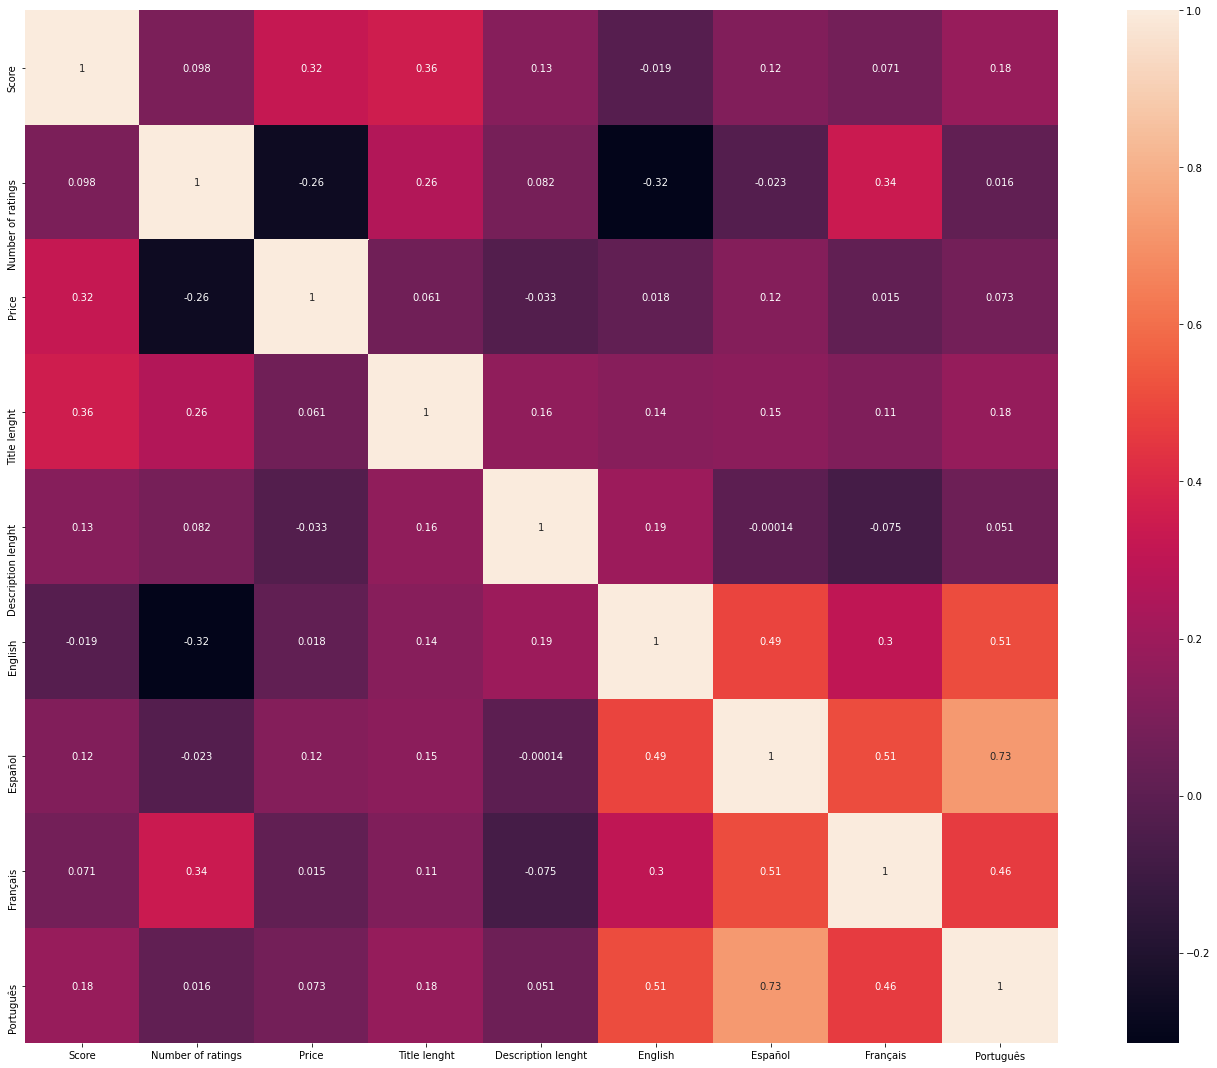

In [484]:
corr_df = df_main.corr()
f, ax = plt.subplots(figsize=(25,19))
sns.heatmap(corr_df, square=True, annot = True, annot_kws={'size':10})

In the previous heatmap it is possible to review the __correlation among the variables__ that I was interested on. Following the criteria described above, __the following variables might represent a relevant correlation__ to consider:

- __English__
- __Portuguese__
- __Spanish__
- __French__

which might means that __most of the things to do offer these languages__ and might represent a consideration for the clients.


### Correlation heatmap for top dataframe

<AxesSubplot:>

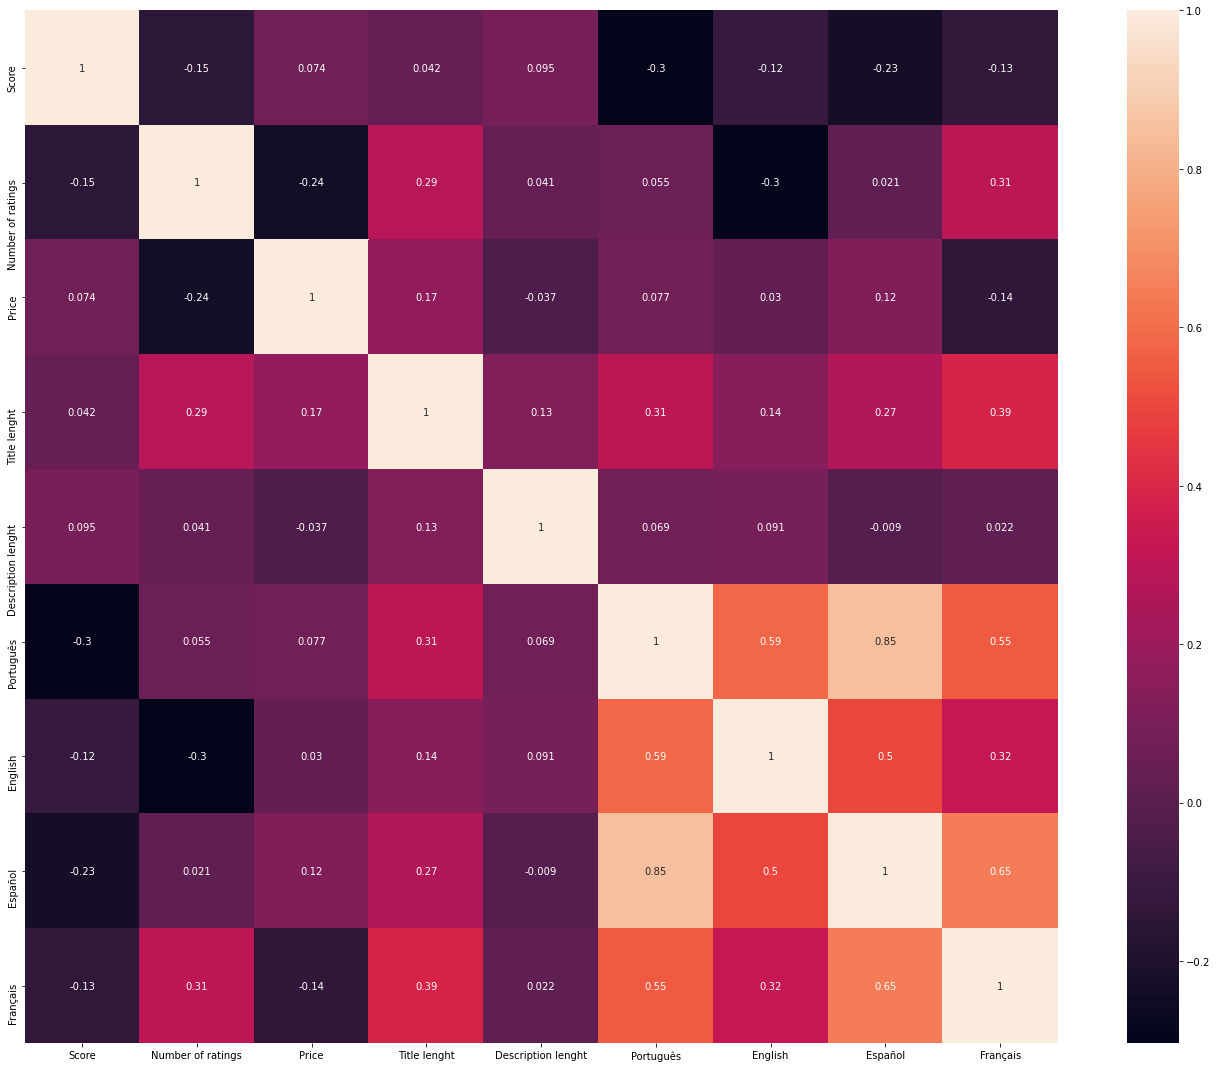

In [485]:
corr_df = df_top.corr()
f, ax = plt.subplots(figsize=(25,19))
sns.heatmap(corr_df, square=True, annot = True, annot_kws={'size':10})


In the previous heatmap it is possible to review the __correlation among the variables__ that I was interested on. Following the criteria described above, __the following variables might represent a relevant correlation__ to consider:

- __Portuguese__
- __Spanish__
- __French__
- __English__

Are these languages a must?



### Correlation heatmap for rest dataframe

<AxesSubplot:>

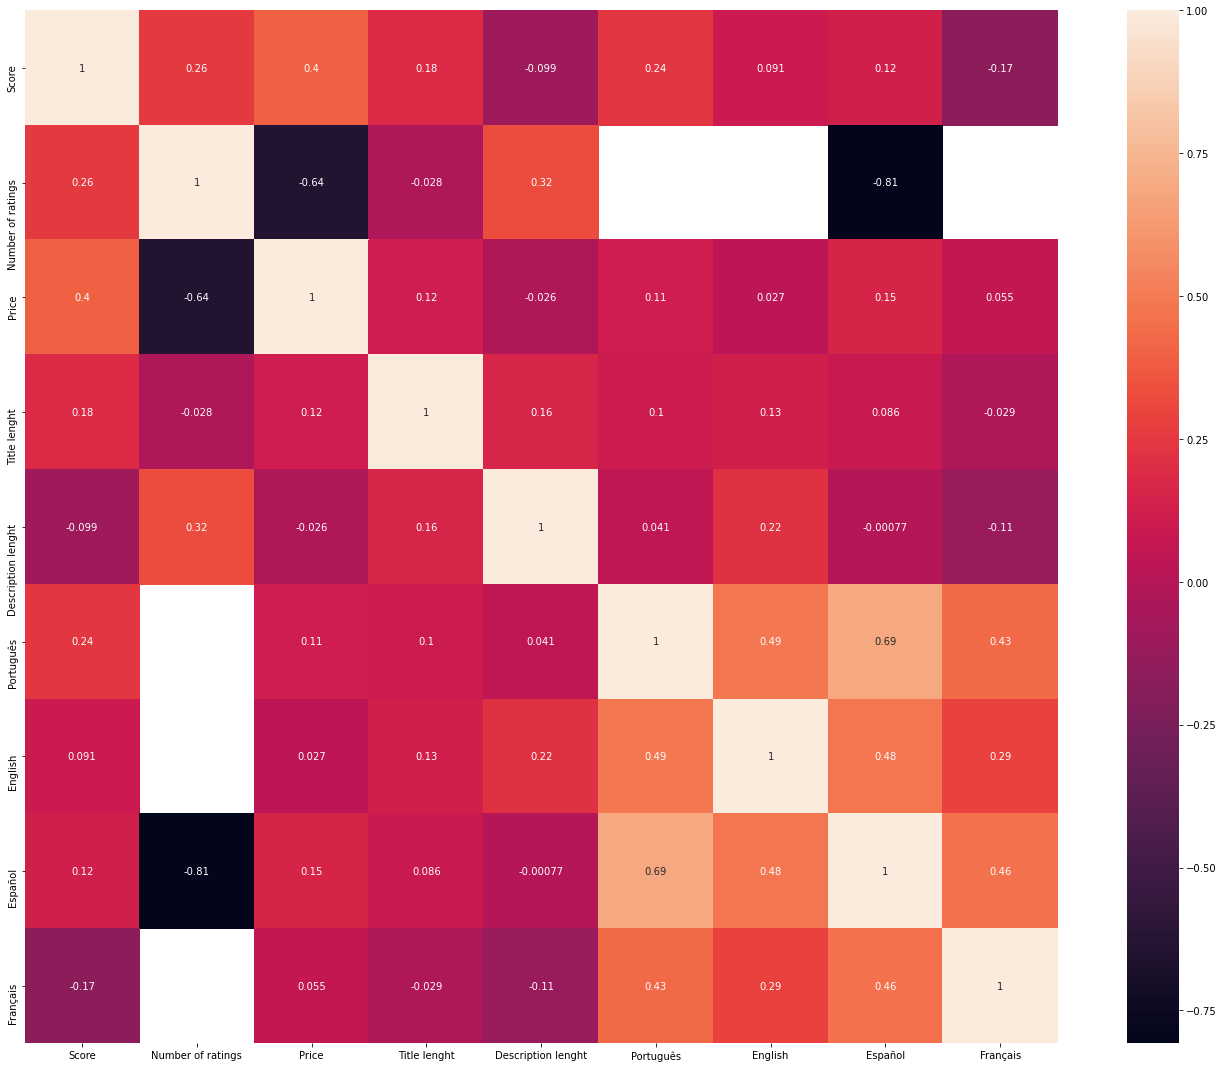

In [486]:
corr_df = df_rest.corr()
f, ax = plt.subplots(figsize=(25,19))
sns.heatmap(corr_df, square=True, annot = True, annot_kws={'size':10})

In the previous heatmap it is possible to see the __correlation among the variables__ that I was interested on. Following the criteria described above, __the following variables might represent a relevant correlation between each other__ interesting to consider.

First, we have:
- __Portuguese__
- __Spanish__
- __French__

as in the top dataframe, this stays the same but with a __significant reduction in the correaltion coefficient.__

Second, we have:
- __Score-Price__
- __Price-Number of ratings__
- __Spanish-Number of ratings__

The __Score-Price correlation__ is in the limit of being a weak correlation, but, __might also tell us that in this case, the price affects the score that the reviewers gave__. 

The __Price-Number of ratings__ is a negative moderate correlation, and tell that the things to do with a higher price has less number of ratings, therefore, the following questions might be asked: __is this because people don't go to the most expensive things to do? is this because people that pays more don't tend to leave reviews?

The __Spanish-Number of ratings__ is a strong negative correlation, __does this means that the services that offer Spanish guide are not that frequented? or that the Spanish spoken people don't tend to give reviews?__ These questions are tricky to answer, but it gives another line of though for another potential analysis of how the languages offered affect the reviews and also to see which country has the 'most reviewers' users in Kayak.

It is feasible to consider that __the score and number of ratings are influenced by the price of the things to do__, for this reason, a __price comparision may be performed__ to investigate more.

## Price comparision analysis

### Price mean, median and mode of the main dataframe

To complement the correlation analysis, the __price analysis__ was conducted __considering the following 3 criterias__:

- __Mean__
- __Median__
- __Mode__

In [448]:
print(df_main['Price'].mean())
print(df_main['Price'].median())
print(df_main['Price'].mode())

152.59851301115242
94.0
0    69.0
dtype: object


### Price mean, median and mode of the top dataframe

In [449]:
print(df_top['Price'].mean())
print(df_top['Price'].median())
print(df_top['Price'].mode())

85.9
76.5
0    52.0
dtype: float64


### Price mean, median and mode of the rest dataframe

In [450]:
print(df_rest['Price'].mean())
print(df_rest['Price'].median())
print(df_rest['Price'].mode())

176.0603015075377
112.0
0    69.0
dtype: float64


After having the results, if we __look at the rest and top dataframes__, there is a __clear difference among the values__.
- The mean of the top things to do is __85.9 GBP v/s 176 GBP__ for the rest of the things to do
- The median for the top ones is __76.5 GBP v/s 112 GBP__ for the rest.
- The mode for the top things to do is __52 GBP v/s 69 GBP__ for the rest. 

given this and the previos heatmap,I came up with the following insights:

- __The top things to do in Porto are__ in average __48.8% cheaper__ than the rest of the things to do, which __might means that the number of ratings they have is because less people go or enjoy the experience as it's overpriced.__
- __The median of the rest of things to do is more expensive__ than the average price of the top things to do.
- __The mode of the rest of things to do is a bit lower__ than the median of the top ones, __maybe there's more affecting the number of ratings.__

_For a first approach, the insights are relevant, but with more data I could probably get more accurate answers_

## Titles & descriptions lenght analysis

To understand __if there is a difference between the lenght of the titles and descriptions__ among the two dataframes of things to do, the __titles & descriptions lenght analysis__ was conducted __considering the following 3 criterias__:

- __Mean__
- __Median__
- __Mode__

In [492]:
print(df_main['Title lenght'].mean())
print(df_main['Title lenght'].median())
print(df_main['Title lenght'].mode())

39.34074074074074
39.0
0    31
1    47
dtype: int64


In [497]:
print(df_top['Title lenght'].mean())
print(df_top['Title lenght'].median())
print(df_top['Title lenght'].mode())

44.92857142857143
47.0
0    47
1    64
dtype: int64


In [498]:
print(df_rest['Title lenght'].mean())
print(df_rest['Title lenght'].median())
print(df_rest['Title lenght'].mode())

37.385
37.5
0    31
dtype: int64


In [499]:
print(df_main['Description lenght'].mean())
print(df_main['Description lenght'].median())
print(df_main[' '].mode())

450.4925925925926
412.5
0    395
1    622
dtype: int64


In [500]:
print(df_top['Description lenght'].mean())
print(df_top['Description lenght'].median())
print(df_top['Description lenght'].mode())

465.04285714285714
426.0
0    304
1    325
2    494
dtype: int64


In [501]:
print(df_rest['Description lenght'].mean())
print(df_rest['Description lenght'].median())
print(df_rest['Description lenght'].mode())

445.4
406.0
0    253
1    374
2    395
3    622
4    772
5    794
dtype: int64


If we __look at the results__, there are __some interesting things to notice__.
- The __title length__ is in average __12.4% bigger in the top things to do.__
- The __median for the title length does not change significantly__, which means that it __is consistent__ among the things to do. 
- The __description length__ of the top things to do __is similar__ than the rest of things to do.

Given this, __is the title length the most important element that the client should consider when publishing a new thing to do?__ For this, some __text analysis__ as with the reviews will be performed to see if it is possible to understand __what is in the text of the top things to do and how this differs(or not)__ from the rest of things to do.  


## Titles & Descriptions text analysis

### Cleaning and preparing data

In [137]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

In [356]:
df_main['Title splitted'] = None
df_main['Description splitted'] = None
df_main['Title'] = df_main['Title'].str.lower()
tmp = df_main['Title'].str.split(r' ')
df_main['Title splitted'] = tmp.apply(lambda x: x)
del(tmp) 
df_main['Description'] = df_main['Description'].str.lower()
tmp = df_main['Description'].str.split(r' ')
df_main['Description splitted'] = tmp.apply(lambda x: x)
del(tmp) 
df_main

,Title,Location,Link,Score,Number of ratings,Price,Currency,Unit,Description,Ticket options,Free cancellation,Languages,Duration,Food and drink,Title lenght,Description lenght,Languages counter,Duration2,Title splitted,Description splitted
0,"douro valley small-group tour with wine tasting, and optional lunch and cruise","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3378804,5.0,10.0,69.0,GBP,person,visit portugal’s prestigious douro valley on this full-day wine tour from porto! famous for its ...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English, Français, Español",1,None,65,622,None,1,"[douro, valley, small-group, tour, with, wine, tasting,, and, optional, lunch, and, cruise]","[visit, portugal’s, prestigious, douro, valley, on, this, full-day, wine, tour, from, porto!, fa..."
1,douro valley wine tour: visit to three vineyards with wine tastings and lunch,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3431622,5.0,10.0,82.0,GBP,person,"if you enjoy wine, this tour is definitively for you!book this tour leaving from porto, and have...",None,None,"Audio guide in Português, English, Français, Español",9,None,64,494,None,9,"[douro, valley, wine, tour:, visit, to, three, vineyards, with, wine, tastings, and, lunch]","[if, you, enjoy, wine,, this, tour, is, definitively, for, you!book, this, tour, leaving, from, ..."
2,porto: 3-hour food and wine tasting tour - guided experience,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3421880,5.0,10.0,52.0,GBP,person,portugal has a mediterranean and atlantic kitchen full of products brought from all over the wor...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English, Français, Español",3,None,47,809,None,3,"[porto:, 3-hour, food, and, wine, tasting, tour, -, guided, experience]","[portugal, has, a, mediterranean, and, atlantic, kitchen, full, of, products, brought, from, all..."
3,"douro valley tour: wine tasting, river cruise and lunch from porto with pickup","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3456320,5.0,10.0,69.0,GBP,person,"spend a full day taking in the landscapes of the douro valley, traveling in a comfortable vehicl...",None,None,None,0,None,64,232,None,0,"[douro, valley, tour:, wine, tasting,, river, cruise, and, lunch, from, porto, with, pickup]","[spend, a, full, day, taking, in, the, landscapes, of, the, douro, valley,, traveling, in, a, co..."
4,port wine lodges tour including 7 wine tastings,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3448902,5.0,10.0,36.0,GBP,person,experience what makes port wine unique and how it distinguishes from other wines. learn how and ...,None,None,None,4,None,39,690,None,4,"[port, wine, lodges, tour, including, 7, wine, tastings]","[experience, what, makes, port, wine, unique, and, how, it, distinguishes, from, other, wines., ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,secrets of porto and douro valley with river cruise and scenic train,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761251,None,None,1012.0,GBP,person,the essential of porto and the best of douro valley5 day packagethis journey will show the best ...,Mobile or paper ticket accepted,None,Audio guide in English,5,Dinner,57,235,None,5,"[secrets, of, porto, and, douro, valley, with, river, cruise, and, scenic, train]","[the, essential, of, porto, and, the, best, of, douro, valley5, day, packagethis, journey, will,..."
266,discover and explore with us the wine region alto douro!,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761252,None,None,1590.0,GBP,person,excursion guests have the opportunity to make an incomparable landscape experience in the midst ...,Mobile or paper ticket accepted,All sales are final. No refund is 

In [143]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/maxrojas/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to /Users/maxrojas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maxrojas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/maxrojas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxrojas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Removing stopwords

In [146]:
from nltk.corpus import stopwords

In [144]:
def remove_stopwords(text):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    return [word for word in text if not word in stop_words]



In [357]:
df_main['Description splitted'] = df_main['Description splitted'].apply(lambda x: remove_stopwords(x))
df_main['Title splitted'] = df_main['Title splitted'].apply(lambda x: remove_stopwords(x))

### Getting most common words, bigrams & trigrams

In [358]:
from collections import  Counter
from collections import defaultdict


In [359]:
def create_corpus(column):
    corpus=[]
    
    for x in column:
        for i in x:
            corpus.append(i)
    return corpus

In [364]:
df_top['Title splitted'] = None
df_top['Description splitted'] = None
df_top['Title'] = df_top['Title'].str.lower()
df_top['Description'] = df_top['Description'].str.lower()
tmp = df_top['Title'].str.split(r' ')
df_top['Title splitted'] = tmp.apply(lambda x: x)
del(tmp) 
tmp = df_top['Description'].str.split(r' ')
df_top['Description splitted'] = tmp.apply(lambda x: x)
del(tmp) 
df_top

/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,Title,Location,Link,Score,Number of ratings,Price,Currency,Unit,Description,Ticket options,Free cancellation,Languages,Duration,Food and drink,Title lenght,Description lenght,Title splitted,Description splitted
0,"douro valley small-group tour with wine tasting, and optional lunch and cruise","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3378804,5.0,10.0,69.0,GBP,person,visit portugal’s prestigious douro valley on this full-day wine tour from porto! famous for its ...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English, Français, Español",1,NaN,65,622,"[douro, valley, small-group, tour, with, wine, tasting,, and, optional, lunch, and, cruise]","[visit, portugal’s, prestigious, douro, valley, on, this, full-day, wine, tour, from, porto!, fa..."
1,douro valley wine tour: visit to three vineyards with wine tastings and lunch,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3431622,5.0,10.0,82.0,GBP,person,"if you enjoy wine, this tour is definitively for you!book this tour leaving from porto, and have...",NaN,NaN,"Audio guide in Português, English, Français, Español",9,NaN,64,494,"[douro, valley, wine, tour:, visit, to, three, vineyards, with, wine, tastings, and, lunch]","[if, you, enjoy, wine,, this, tour, is, definitively, for, you!book, this, tour, leaving, from, ..."
2,porto: 3-hour food and wine tasting tour - guided experience,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3421880,5.0,10.0,52.0,GBP,person,portugal has a mediterranean and atlantic kitchen full of products brought from all over the wor...,Mobile or paper ticket accepted,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English, Français, Español",3,NaN,47,809,"[porto:, 3-hour, food, and, wine, tasting, tour, -, guided, experience]","[portugal, has, a, mediterranean, and, atlantic, kitchen, full, of, products, brought, from, all..."
3,"douro valley tour: wine tasting, river cruise and lunch from porto with pickup","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3456320,5.0,10.0,69.0,GBP,person,"spend a full day taking in the landscapes of the douro valley, traveling in a comfortable vehicl...",NaN,NaN,NaN,0,NaN,64,232,"[douro, valley, tour:, wine, tasting,, river, cruise, and, lunch, from, porto, with, pickup]","[spend, a, full, day, taking, in, the, landscapes, of, the, douro, valley,, traveling, in, a, co..."
4,port wine lodges tour including 7 wine tastings,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3448902,5.0,10.0,36.0,GBP,person,experience what makes port wine unique and how it distinguishes from other wines. learn how and ...,NaN,NaN,NaN,4,NaN,39,690,"[port, wine, lodges, tour, including, 7, wine, tastings]","[experience, what, makes, port, wine, unique, and, how, it, distinguishes, from, other, wines., ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,"porto city tour full day - river cruise, wine cellars and lunch - small group","Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3546506,4.0,3.0,78.0,GBP,person,"porto world heritagea thorough tour around the city that gave its name to the country, portus ca...",NaN,NaN,"Audio guide in Português, English",9,LunchBreakfast,60,729,"[porto, city, tour, full, day, -, river, cruise,, wine, cellars, and, lunch, -, small, group]","[porto, world, heritagea, thorough, tour, around, the, city, that, gave, its, name, to, the, cou..."
66,guided port wine walking tour,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3485172,4.0,4.0,26.0,GBP,person,"a local guide will be waiting for you, ready to take you on a journey through the best wines of ...",NaN,"For a full refund, cancel at least 24 hours before the scheduled departure time.","Audio guide in Português, English, Español",3,NaN,25,575,"[guided, port, wine, walking,

In [537]:
df_rest['Title splitted'] = None
df_rest['Description splitted'] = None
df_rest['Title'] = df_rest['Title'].str.lower()
df_rest['Title'] = df_rest['Title'].str.replace('&','')
df_rest['Title'] = df_rest['Title'].str.replace('-','')
df_rest['Description'] = df_rest['Description'].str.lower()
df_rest['Description'] = df_rest['Description'].str.replace('&','')
df_rest['Description'] = df_rest['Description'].str.replace('-','')
tmp = df_rest['Title'].str.split(r' ')
df_rest['Title splitted'] = tmp.apply(lambda x: x)
del(tmp) 
tmp = df_rest['Description'].str.split(r' ')
df_rest['Description splitted'] = tmp.apply(lambda x: x)
del(tmp) 
df_rest

/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,Title,Location,Link,Score,Number of ratings,Price,Currency,Unit,Description,Ticket options,...,Duration,Food and drink,Title lenght,Description lenght,Title splitted,Description splitted,Português,English,Español,Français
70,fado dinner with panoramic night view of porto,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3387226,3.0,5.0,60.0,GBP,person,experience porto’s cultural heritage in style during this 4hour fado show and dinner. travel gla...,NaN,...,4,NaN,39,343,"[fado, dinner, with, panoramic, night, view, of, porto]","[experience, porto’s, cultural, heritage, in, style, during, this, 4hour, fado, show, and, dinne...",1,1,0,0
71,douro valley and wine day trip from porto with cruise,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3461928,3.0,3.0,60.0,GBP,person,"join a full day tour, perfect for port wine lovers and to discover the historical villages of th...",Mobile or paper ticket accepted,...,9,NaN,44,508,"[douro, valley, and, wine, day, trip, from, porto, with, cruise]","[join, a, full, day, tour,, perfect, for, port, wine, lovers, and, to, discover, the, historical...",1,1,1,0
72,porto douro valley fullday wine tasting river cruise with lunch,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3606978,3.0,2.0,69.0,GBP,person,experience the romance of the douro valley wine region on a 9hour tour. visit 2 wine producers t...,Mobile or paper ticket accepted,...,9,NaN,54,210,"[porto, douro, valley, fullday, wine, tasting, , river, cruise, with, lunch]","[experience, the, romance, of, the, douro, valley, wine, region, on, a, 9hour, tour., visit, 2, ...",1,1,1,0
73,douro valley fullday private tour from porto,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3492664,3.0,1.0,302.0,GBP,person,enjoy a wonderful fullday tour in douro valley with lunch of typical dishes of the region. you'l...,Mobile or paper ticket accepted,...,9,NaN,38,205,"[douro, valley, fullday, private, tour, from, porto]","[enjoy, a, wonderful, fullday, tour, in, douro, valley, with, lunch, of, typical, dishes, of, th...",1,1,1,0
74,douro valley smallgroup tour from porto with wine tasting and river cruise,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3387248,1.0,3.0,69.0,GBP,person,join us on this fascinating tour of the douro valley. start by being picked up from your hotel i...,Mobile or paper ticket accepted,...,9,NaN,63,358,"[douro, valley, smallgroup, tour, from, porto, with, wine, tasting, and, river, cruise]","[join, us, on, this, fascinating, tour, of, the, douro, valley. start, by, being, picked, up, fr...",1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,secrets of porto and douro valley with river cruise and scenic train,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761251,NaN,NaN,1012.0,GBP,person,the essential of porto and the best of douro valley5 day packagethis journey will show the best ...,Mobile or paper ticket accepted,...,5,Dinner,57,235,"[secrets, of, porto, and, douro, valley, with, river, cruise, and, scenic, train]","[the, essential, of, porto, and, the, best, of, douro, valley5, day, packagethis, journey, will,...",0,1,0,0
266,discover and explore with us the wine region alto douro!,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761252,NaN,NaN,1590.0,GBP,person,excursion guests have the opportunity to make an incomparable landscape experience in the midst ...,Mobile or paper ticket accepted,...,8,BreakfastSnacksLunch,46,126,"[discover, and, explore, with, us, the, wine, region, alto, douro!]","[excursion, guests, have, the, opportunity, to, make, an, incomparable, landscape, experience, i...",0,0,0,0
267,douro valley guided tours from porto,"Porto, Portugal",https://www.kayak.co.uk/things-to-do/details/3761253,NaN,NaN,1753.0,GBP,person,unique experience in one of the most beautiful demarcated wine regions in the world.unesco herit...,Mobile or paper ticket accepted,...,9

In [538]:
df_top['Description splitted'] = df_top['Description splitted'].apply(lambda x: remove_stopwords(x))
df_top['Title splitted'] = df_top['Title splitted'].apply(lambda x: remove_stopwords(x))

/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [539]:
df_rest['Description splitted'] = df_rest['Description splitted'].apply(lambda x: remove_stopwords(x))
df_rest['Title splitted'] = df_rest['Title splitted'].apply(lambda x: remove_stopwords(x))

/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Unigram, bigram & trigram analysis for descriptions and titles

### Unigrams of the descriptions

In [519]:
corpus=create_corpus(df_top['Description splitted'])
counter=Counter(corpus)
most_description=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
        x.append(word)
        y.append(count)
most_description[:15]

[('wine', 97),
 ('douro', 71),
 ('tour', 68),
 ('visit', 55),
 ('port', 55),
 ('enjoy', 51),
 ('city', 39),
 ('porto', 36),
 ('local', 35),
 ('best', 32),
 ('wines', 31),
 ('portuguese', 30),
 ('region', 29),
 ('tasting', 27),
 ('traditional', 25)]

In [520]:
corpus=create_corpus(df_rest['Description splitted'])
counter=Counter(corpus)
most_description=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
        x.append(word)
        y.append(count)
most_description[:15]

[('wine', 239),
 ('douro', 208),
 ('porto', 108),
 ('visit', 107),
 ('tour', 103),
 ('port', 97),
 ('local', 88),
 ('best', 85),
 ('one', 76),
 ('city', 70),
 ('taste', 68),
 ('valley', 65),
 ('experience', 62),
 ('portuguese', 60),
 ('enjoy', 54)]

__The 15 most common unigrams of the descriptions per dataframe are displayed in the previous outputs__ and it can give us a first glimpse of what does the descriptions includes. it looks like almost all the words are the same rather than a couple that are:
- __Region__
- __Tasting__
- __Traditional__

Which might reveal __a potential trend__ showing that most of the descriptions of the top things to do talks about these 3 things apart from the city, Douro, Wine and other words that are describing what the activity is.

As a potential analysis to conduct in the future, there's the possibility to extend the analysis per region and analyze the most common adjetives used for the things to do and give some suggestions to put in their publications.

### Bigrams of the descriptions

In [515]:
bigrams_df_top=get_bigrams(df_top['Description splitted'].astype(str))
bigrams_df_top[:15]

[('port wine', 44),
 ('douro valley', 24),
 ('douro river', 19),
 ('wine tasting', 16),
 ('world heritage', 15),
 ('full day', 11),
 ('day tour', 11),
 ('unesco world', 10),
 ('city porto', 10),
 ('wine region', 8),
 ('port wines', 8),
 ('best douro', 8),
 ('boat ride', 7),
 ('douro region', 7),
 ('heritage site', 7)]

In [516]:
bigrams_df_rest=get_bigrams(df_rest['Description splitted'].astype(str))
bigrams_df_rest[:15]

[('douro valley', 98),
 ('port wine', 76),
 ('douro river', 42),
 ('wine region', 32),
 ('wine tasting', 32),
 ('olive oil', 29),
 ('we ll', 20),
 ('world heritage', 19),
 ('one beautiful', 16),
 ('douro wine', 14),
 ('city porto', 14),
 ('region world', 14),
 ('wine olive', 14),
 ('join us', 12),
 ('boat trip', 12)]

__The 15 most common bigrams of the descriptions per dataframe are displayed in the previous outputs__. In general, __most of the elements are similar__, which might not reveal a real difference between the descriptions of the top things to do and the rest, but __what can reveal is the most common things offered in the descriptions of the things to do__ that __can be interesting for a client__ that wish to write a description for his new publication in Kayak.

Also, __there is some relations between the bigrams in the reviews and the descriptions__, so another interesting approach should be to __understand which ones of these elements from the bigrams and maybe trigrams are mentioned by the reviewers__ so the clients might put more emphasis in those ones and __try to maximize the impact of their reviews.__

### Trigrams of the descriptions

In [517]:
trigrams_df_top=get_trigrams(df_top['Description splitted'].astype(str))
trigrams_df_top[:15]

[('unesco world heritage', 10),
 ('world heritage site', 7),
 ('full day tour', 5),
 ('cruise douro river', 5),
 ('port wine tasting', 5),
 ('visit port wine', 4),
 ('day tour includes', 4),
 ('port wine cellars', 4),
 ('along douro river', 3),
 ('trying local gastronomy', 3),
 ('heritage site unesco', 3),
 ('vila nova de', 3),
 ('nova de gaia', 3),
 ('famous port wine', 3),
 ('port wine cellar', 3)]

In [518]:
trigrams_df_rest=get_trigrams(df_rest['Description splitted'].astype(str))
trigrams_df_rest[:15]

[('wine olive oil', 14),
 ('douro wine region', 10),
 ('wine region world', 10),
 ('panoramic sightseeing douro', 9),
 ('sightseeing douro river', 9),
 ('unesco world heritage', 7),
 ('world heritage site', 7),
 ('222 considered best', 6),
 ('considered best road', 6),
 ('best road world', 6),
 ('tour douro valley', 5),
 ('alto douro wine', 5),
 ('pastel de nata', 5),
 ('heart douro valley', 5),
 ('port wine olive', 5)]

__The 15 most common trigrams of the descriptions per dataframe are displayed in the previous outputs__. Here __there are some differences__ like the top ranked ones __mention Vila nova de Gaia__ a city next to Porto, that might be interesting for the people that goes to Porto. Also, __the day tours are common__ in the top things to do as well as __going to the cellars__ and __cruise the douro river__

This insights might be relevant for the clients that want to open new things to do in Porto.

_With more data from different places this analysis could provide relevant information to open new opportunities in different regions_

### Unigrams of the titles

In [546]:
corpus=create_corpus(df_top['Title splitted'])
counter=Counter(corpus)
most_title=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
        x.append(word)
        y.append(count)
most_title[:15]

[('wine', 49),
 ('tour', 44),
 ('porto', 35),
 ('douro', 28),
 ('valley', 23),
 ('lunch', 22),
 ('tasting', 20),
 ('private', 15),
 ('cruise', 14),
 ('tastings', 12),
 ('river', 11),
 ('city', 10),
 ('visit', 9),
 ('food', 8),
 ('&', 8)]

In [549]:
corpus=create_corpus(df_rest['Title splitted'])
counter=Counter(corpus)
most_title=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
        x.append(word)
        y.append(count)
most_title[:15]

[('tour', 113),
 ('douro', 92),
 ('wine', 83),
 ('porto', 71),
 ('private', 69),
 ('valley', 64),
 ('', 57),
 ('tasting', 32),
 ('lunch', 25),
 ('day', 23),
 ('food', 20),
 ('experience', 20),
 ('cruise', 11),
 ('fullday', 11),
 ('port', 10)]

__The 15 most common unigrams of the titles per dataframe are displayed in the previous outputs__ and it can give us a first glimpse of what does the Titles includes. Most of the words are the same in both dataframes, but, for the top things to do, there are some differences which might give some potential keywords to use in the Titles. These words are:

- __River__
- __Visit__
- __City__

To check if this pattern continue with the bigram the analysis is conducted below.

### Bigrams  of the titles

In [524]:
bigrams_df_top=get_bigrams(df_top['Title splitted'].astype(str))
bigrams_df_top[:15]

[('douro valley', 23),
 ('wine tasting', 20),
 ('small group', 13),
 ('porto city', 10),
 ('river cruise', 9),
 ('wine tastings', 8),
 ('tour wine', 7),
 ('wine tour', 7),
 ('tour porto', 7),
 ('valley wine', 6),
 ('valley tour', 6),
 ('lunch wine', 6),
 ('city tour', 6),
 ('full day', 6),
 ('food wine', 5)]

In [552]:
bigrams_df_rest=get_bigrams(df_rest['Title splitted'].astype(str))
bigrams_df_rest[:15]

[('douro valley', 68),
 ('private tour', 31),
 ('wine tasting', 22),
 ('tour porto', 16),
 ('wine tour', 16),
 ('tour douro', 12),
 ('valley private', 12),
 ('port wine', 10),
 ('valley tour', 10),
 ('valley wine', 9),
 ('full day', 9),
 ('private douro', 9),
 ('day tour', 9),
 ('day private', 8),
 ('tour lunch', 8)]

__The 15 most common biigrams of the titles per dataframe are displayed in the previous outputs__ and it can give us a better understanding of what does the titles includes. In this part of the analysis, it is more clear how the titles per dataframe differs.

The titles of the top things to do tend to include bigrams like:
- __City tour__
- __River cruise__
- __Small group__

The previous bigrams are __also mentioned in the results of the reviews' analysis__ above, which can means that these type of activities are the ones that the users write reviews given that they like it enough to give it a score in Kayak.

In the other hand, the titles of the rest of the things to do tend to include more the private tours. given this information, __is the people prefering to have a small group tour with more people rather than a private one?__



### Trigrams  of the titles

In [526]:
trigrams_df_top=get_trigrams(df_top['Title splitted'].astype(str))
trigrams_df_top[:15]

[('douro valley wine', 6),
 ('porto city tour', 6),
 ('tour wine tasting', 5),
 ('douro valley tour', 5),
 ('wine tastings lunch', 4),
 ('tour lunch wine', 4),
 ('lunch wine tasting', 4),
 ('small group tour', 3),
 ('valley wine tour', 3),
 ('wine tasting river', 3),
 ('tasting river cruise', 3),
 ('river cruise lunch', 3),
 ('full day tour', 3),
 ('tour visit three', 2),
 ('visit three vineyards', 2)]

In [525]:
trigrams_df_rest=get_trigrams(df_rest['Title splitted'].astype(str))
trigrams_df_rest[:15]

[('douro valley private', 12),
 ('douro valley tour', 10),
 ('tour douro valley', 10),
 ('douro valley wine', 9),
 ('private douro valley', 9),
 ('full day private', 8),
 ('day private tour', 8),
 ('valley private tour', 8),
 ('private tour included', 6),
 ('douro valley full', 5),
 ('valley full day', 5),
 ('food wine tour', 5),
 ('lunch wine tasting', 5),
 ('full day tour', 5),
 ('full day douro', 5)]

__The 15 most common trigrams of the titles per dataframe are displayed in the previous outputs__. In the top things to do again are included keywords regarding small group tours and titles related to cruising the river and in the rest of the things to do tend more to the private tours.

This could means that __the tours that are made for small groups or related to the river in Porto are more likely to receive reviews__, so, __is this because the tours are better in terms of quality and have happier costumers?__ or maybe __it has more volume of people so they are more likely to have reviews?__

Both makes me think that it is a good option to offer these type of tours in Kayak as they tend to have better rating in the platform, but to be able to answer these questions with more precision, a more In-depth analysis should be conducted as it is hard to tell only with the scraped data.

## About analysis

For this part of the analysis of the features from the About section of the thing to do, I tried to __check if there's a difference in the presence of these elements in the top and the rest of things to do.__ The following variables were analyzed:

- __Free cancellation__
- __Languages__
- __Ticket options__
- __Duration__

As the number of observations is different per dataframe I conducted an analysis considering the percentage of the elements over the specific dataframe.

### getting total values to calculate %

In [187]:
total_top = len(df_top)
total_rest = len(df_rest)

### Free cancellation %

In [189]:
free_cancellation_top = sum(df_top['Free cancellation'].value_counts())/total_top*100
free_cancellation_top

57.14285714285714

In [241]:
free_cancellation_rest = sum(df_rest['Free cancellation'].value_counts())/total_rest*100
free_cancellation_rest

60.0

If we compare if both dataframes include free cancellation policies, it is clear that __there is no much difference between both as it only varies a 3%.__ 

## Languages % per df

In [571]:
print(df_top['English'].value_counts()[1]/total_top*100)
print(df_top['Español'].value_counts()[1]/total_top*100)
print(df_top['Français'].value_counts()[1]/total_top*100)
print(df_top['Português'].value_counts()[1]/total_top*100)
print((df_top['English'].value_counts()[1]/total_top*100 + df_top['Español'].value_counts()[1]/total_top*100 + df_top['Français'].value_counts()[1]/total_top*100 + df_top['Português'].value_counts()[1]/total_top*100)/4)


87.14285714285714
62.857142857142854
41.42857142857143
70.0
65.35714285714286


In [572]:
print(df_rest['English'].value_counts()[1]/total_rest*100)
print(df_rest['Español'].value_counts()[1]/total_rest*100)
print(df_rest['Français'].value_counts()[1]/total_rest*100)
print(df_rest['Português'].value_counts()[1]/total_rest*100)
print((df_rest['English'].value_counts()[1]/total_rest*100 + df_rest['Español'].value_counts()[1]/total_rest*100 + df_rest['Français'].value_counts()[1]/total_rest*100 + df_rest['Português'].value_counts()[1]/total_rest*100)/4)


84.5
56.00000000000001
32.0
56.49999999999999
57.25


Regarding the languages offered by the things to do in Porto, the languages were checked individually, as a first glimpse it is possible to notice that __more things to do in the top dataframe offer any of the languages__ than the rest of the things to do, with a __difference in the mean of 8%__ and the findings are the following:

- English does not change significantly with __only a 2.5% more__ in the top things to do.
- Spanish has a __differente of 6%__ in favour of the top things to do.
- French is the language with the lowest presence in both of the dataframes and the __difference between both is 9%.__
- Portuguese has the __biggest difference of 13.5%__ between the 2 dataframes.

As a conclusion, it is likely that the languages offer for the guided tours are relevant for getting more reviews and a better ranking in the platform, this also is supported as in the reviews people was talking about the tour guides which reveals that is something important for the tourists. This analysis might be supported by checking the nationality of the reviewers and compare if the distribution among nationalities and the languages has a correlation, which can give a stronger support to this analysis.

### Ticket options %

In [244]:
ticket_options_top = sum(df_top['Ticket options'].value_counts())/total_top*100
ticket_options_top

40.0

In [245]:
ticket_options_rest = sum(df_rest['Ticket options'].value_counts())/total_rest*100
ticket_options_rest

56.49999999999999

Regarding the ticket options included, __there is a 16.5% of difference__ between the rest of the things to do and the top ones. This means that the top attractions in general does not include this information, at least in this category of things to do in the city of Porto. It would be interesting to expand the scope of this part of the analysis with more observations to check if this trends can be confirmed

## Duration analysis

In [315]:
df_top['Duration'] = df_top['Duration'].str[0]
df_top['Duration'] = df_top['Duration'].fillna(0)
df_top['Duration'].astype(int).mean()

/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


4.5285714285714285

In [316]:
df_rest['Duration'] = df_rest['Duration'].str[0]
df_rest['Duration'] = df_rest['Duration'].fillna(0)
df_rest['Duration'].astype(int).mean()

/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxrojas/.conda/envs/pythonProject/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


4.72

<AxesSubplot:ylabel='None'>

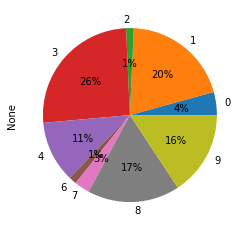

In [587]:
df_top.groupby(['Duration']).size().plot.pie(autopct='%1.0f%%')

<AxesSubplot:ylabel='None'>

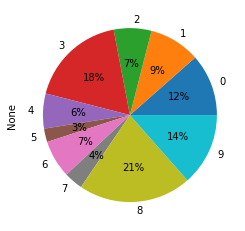

In [588]:
df_rest.groupby(['Duration']).size().plot.pie(autopct='%1.0f%%')

The previous analyzis reveales that __in average all the things to do are 4.5 - 5 hours experiences.__
In order to check if there is a difference in the distribution of the durations change between the top things to do and the rest 2 pie charts were created and those represent the things to do duration's frequency.

Regarding the top things to do, it's clear that most of the experiences last __between 3-4 hours and 8-9 hours__, __followed by 1 hour experiences__.

In the dataframe of the rest things to do, there is also a majority for the range __8-9 hours__, the __3-4 range__ it's also the second one but it is smaller. This graph is better distributed having interesting proportions in durations like __2,6,7 and 5 hours.__

This might tell that the __users tend to prefer the activities__ that are either __1 hour experience or of a duration between the ranges described before__. It would be a __potential recommendation__ for the clients to __aim for these durations for new activities as apparently are more likely to have top ratings.__

### Conclusions

As the reviews analysis, __the previous analysis give relevant insights and open key questions__ that helps shaping a specific study of how the top things to do in Porto listed are different from the rest listed in Kayak. __This findings can be supported and compared__ with other cities if the information is available, this could lead to interesting new tools that can be offered for the clients of Kayak that want to offer their experiences in the platform, specially if it's combined with other type of analysis as the Reviews analysis or an analysis of the characteristics of the users that search and rate these experiences and others and as i mentioned before, __this analysis is only a first approach to a more In-depth analysis__ , but, with the right tools I can extend __this analysis to different cities, countries and regions of the world__ to have a better perspective on the relation between the variables previously analyzed.

#### potential improvements for clients

As potential improvements to add to the features offered to the client using the information of this analysis I believe might be interesting:

- __Recommend languages that they should include in the new experiences they want to offer in a certain location.__

- __The range of price that they should aim for a new experience based on the prices of the top ranked ones in Kayak.__

- __Lenght and Keywords to use in the title & description based on the ones included in the top ranked experiences in a specific location.__

- __What features to include in the about section of the new experience.__

- __Give insights of which languages should the experience include.__

- __How long should the experience should be based on similar experiences and what people tend to prefer.__





#### potential improvements for the model

As potential improvements for the model:
- __Conduct Sentiment analysis.__

- __Analysis per sentiment.__

- __Topic modelling.__

- __Analysis per different regions.__

- __Improve data cleaning and number of observations.__

- __Analysis per year to see how the people has change the narrative over time.__

- __Analysis considering the information of the users to analyze considering gender, age, location, among others.__


